# **Способ №1**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm  # progress bar

In [ ]:
def read_image(path):
    img = cv2.imread(path)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_gray, img, img_rgb

def SIFT(img):
    siftDetector= cv2.SIFT_create()
    kp, des = siftDetector.detectAndCompute(img, None)
    return kp, des

def plot_sift(gray, rgb, kp):
    tmp = rgb.copy()
    img = cv2.drawKeypoints(gray, kp, tmp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

def matcher(kp1, des1, img1, kp2, des2, img2, threshold):
    # Brute force matcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    good = []
    for m,n in matches:
        if m.distance < threshold * n.distance:
            good.append([m])

    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches

def plot_matches(matches, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type

    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')

    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)

    plt.show()

def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H / H[2, 2] # standardize to let w*H[2,2] = 1
    return H

def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx ]
    return np.array(point)

def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp / temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors

def ransac(matches, threshold, iters):
    num_best_inliers = 0

    for i in range(iters):
        points = random_point(matches)
        H = homography(points)

        #  avoid dividing by zero
        if np.linalg.matrix_rank(H) < 3:
            continue

        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()

    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

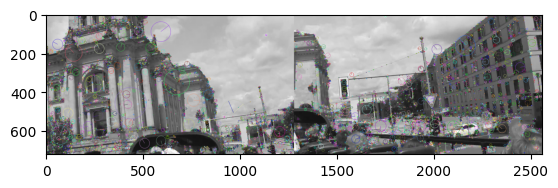

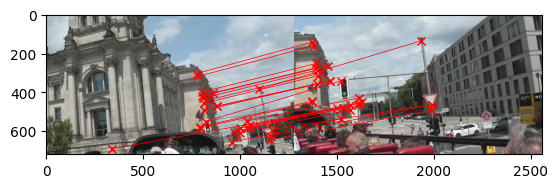

inliers/matches: 8/27


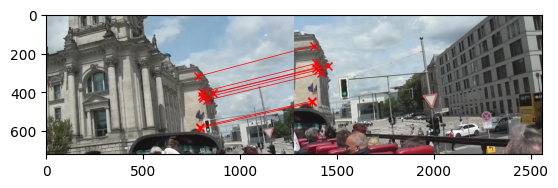

In [ ]:
left_gray, left_origin, left_rgb = read_image('003.jpg')
right_gray, right_origin, right_rgb = read_image('004.jpg')

# (Результаты лучше с серым изображением)
kp_left, des_left = SIFT(left_gray)
kp_right, des_right = SIFT(right_gray)

kp_left_img = plot_sift(left_gray, left_rgb, kp_left)
kp_right_img = plot_sift(right_gray, right_rgb, kp_right)
total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)
plt.imshow(total_kp)

matches = matcher(kp_left, des_left, left_rgb, kp_right, des_right, right_rgb, 0.5)

total_img = np.concatenate((left_rgb, right_rgb), axis=1)
plot_matches(matches, total_img) # Good matches

inliers, H = ransac(matches, 0.5, 2000)

plot_matches(inliers, total_img) # show inliers matches

In [ ]:
def stitch_img(left, right, H):
    print("stiching image ...")

    # Convert to double and normalize. Avoid noise.
    left = cv2.normalize(left.astype('float'), None,
                            0.0, 1.0, cv2.NORM_MINMAX)
    # Convert to double and normalize.
    right = cv2.normalize(right.astype('float'), None,
                            0.0, 1.0, cv2.NORM_MINMAX)

    # left image
    height_l, width_l, channel_l = left.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)

    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    # right image
    warped_l = cv2.warpPerspective(src=left, M=H, dsize=size)

    height_r, width_r, channel_r = right.shape

    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    size = (width_new, height_new)


    warped_r = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)

    black = np.zeros(3)  # Black pixel.

    # Stitching procedure, store results in warped_l.
    for i in tqdm(range(warped_r.shape[0])):
        for j in range(warped_r.shape[1]):
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]

            if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_l
            elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_r
            elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = (pixel_l + pixel_r) / 2
            else:
                pass

    stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :]
    return stitch_image

stiching image ...


  0%|          | 0/929 [00:00<?, ?it/s]

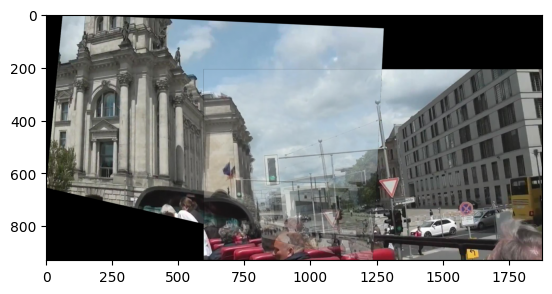

In [ ]:
plt.imshow(stitch_img(left_rgb, right_rgb, H))

# ❌**Способ №2 (ideal, but built-in Stitcher)**

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def display_image_comparison(original, augmented):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(original)
    ax[0].set_title("Original")
    ax[1].imshow(augmented)
    ax[1].set_title("Augmented")
    plt.tight_layout()
    plt.show()

def display_image(image):
    plt.imshow(image)
    plt.title("Image")
    plt.show()

def read_rgb_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def stitch_images(images):
    stitcher = cv2.Stitcher_create()
    _ , result = stitcher.stitch(images)
    return result

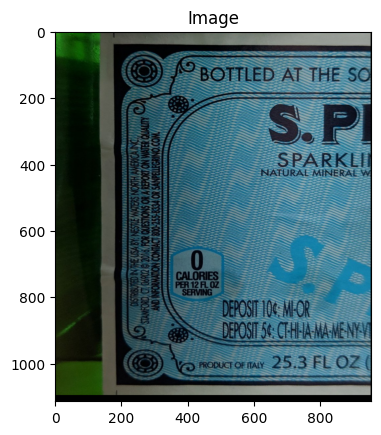

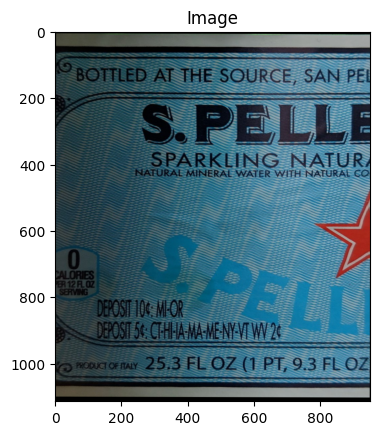

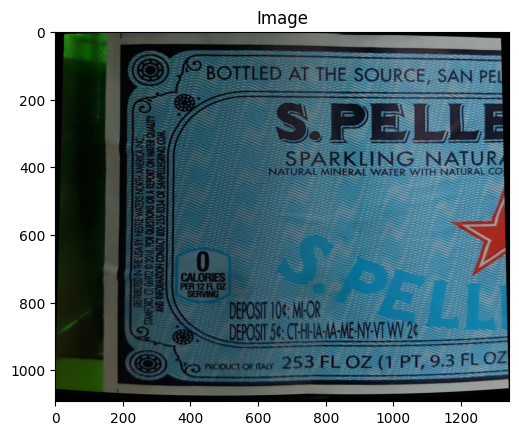

In [ ]:
imgs = [read_rgb_image('1.png'), read_rgb_image('2.png')]
[display_image(i) for i in imgs]

y = stitch_images(imgs)
display_image(y)

# **Способ №3**

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def show_image(image, title=""):
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
# Загрузка изображений
image_paths = ['1.png', '2.png']
num_images = len(image_paths)
images = [cv.imread(path) for path in image_paths]
grayscale_images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

In [ ]:
# Инициализация SIFT и BFMatcher (Brute Force)
sift = cv.SIFT_create()
bf = cv.BFMatcher()
# FLANN_INDEX_KDTREE = 0
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
# search_params = dict(checks=200)  # количество проверок для улучшения поиска
# flann = cv2.FlannBasedMatcher(index_params, search_params)

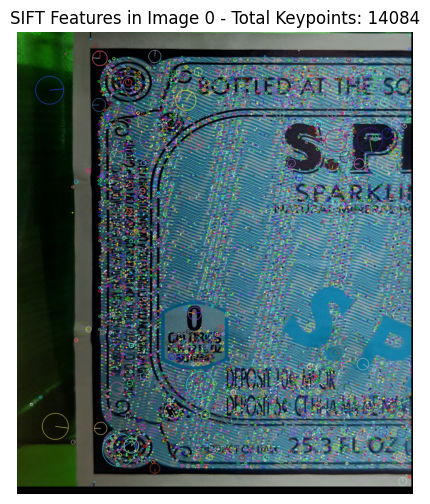

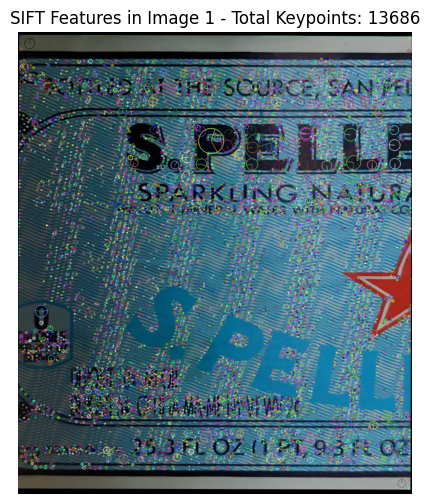

In [ ]:
keypoints_list = []
descriptors_list = []

# Детекция ключевых точек и вычисление дескрипторов
for idx, gray_img in enumerate(grayscale_images):
    kpts, dpts = sift.detectAndCompute(gray_img, None)
    keypoints_list.append(kpts)
    descriptors_list.append(dpts)

    # Визуализация ключевых точек
    img_with_keypoints = cv.drawKeypoints(images[idx], kpts, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv.cvtColor(img_with_keypoints, cv.COLOR_BGR2RGB))
    plt.title(f'SIFT Features in Image {idx} - Total Keypoints: {len(kpts)}')
    plt.axis('off')
    plt.show()

In [ ]:
H_cumulative = np.eye(3, dtype=np.float32)
H_list = [H_cumulative]

# Процесс вычисления гомографии и совмещения изображений
for i in range(1, len(images)):
    # Сопоставление дескрипторов с помощью BFMatcher с kNN
    matches = bf.knnMatch(descriptors_list[i - 1], descriptors_list[i], k=2)

    # Применение фильтра для отбора хороших совпадений
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    print(f"Number of matches between Image {i-1} and Image {i}: {len(good_matches)}")

    if len(good_matches) > 15:
        # Извлечение ключевых точек для расчета гомографии
        src_pts = np.float32([keypoints_list[i - 1][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_list[i][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Вычисление гомографии с использованием RANSAC
        H, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)
        if H is None:
            print(f"Homography could not be computed between Image {i-1} and Image {i}")
            continue

        # Визуализация лучших совпадений после применения фильтра Лоу и RANSAC
        inliers = mask.ravel().tolist()
        inlier_matches = [good_matches[j] for j in range(len(good_matches)) if inliers[j]]
        img_inlier_matches = cv.drawMatches(
            images[i - 1], keypoints_list[i - 1], images[i], keypoints_list[i], inlier_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.figure(figsize=(12, 6))
        plt.imshow(cv.cvtColor(img_inlier_matches, cv.COLOR_BGR2RGB))
        plt.title(f'Inlier (True) Matches Between Image {i-1} and Image {i} (After RANSAC)')
        plt.axis('off')
        plt.show()

        # Обновление кумулятивной гомографии
        H_cumulative = H_cumulative @ H
        H_list.append(H_cumulative)

In [ ]:
# Определение размера итогового изображения
min_x = min_y = max_x = max_y = 0
for i in range(num_images):
    height, width = images[i].shape[:2]
    corners = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32).reshape(-1, 1, 2)
    transformed_corners = cv.perspectiveTransform(corners, H_list[i])
    min_x = min(min_x, transformed_corners[:, 0, 0].min())
    min_y = min(min_y, transformed_corners[:, 0, 1].min())
    max_x = max(max_x, transformed_corners[:, 0, 0].max())
    max_y = max(max_y, transformed_corners[:, 0, 1].max())

output_width = int(max_x - min_x)
output_height = int(max_y - min_y)

In [ ]:
# Коррекция для обработки отрицательных координат
translation_dist = [-min_x, -min_y]
translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]], dtype=np.float32)

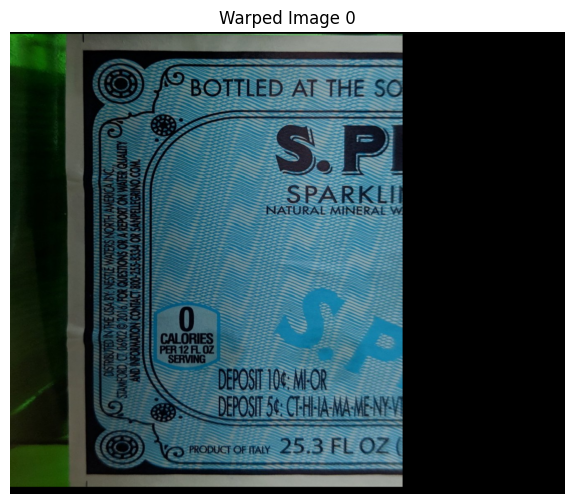

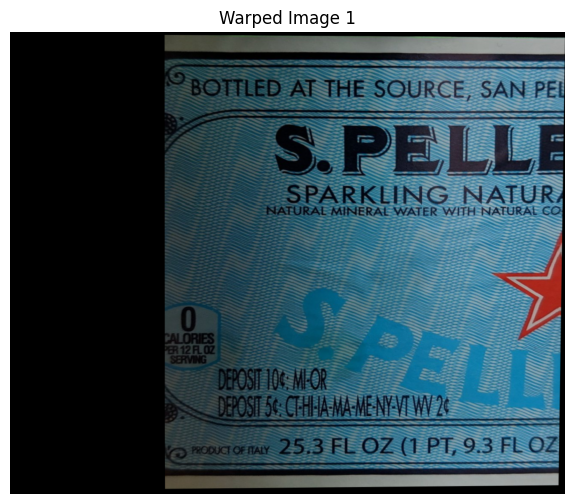

In [ ]:
output_canvas = np.zeros((output_height, output_width, 3), dtype=np.uint8)

# Проецирование и объединение изображений
for i in range(num_images):
    H_translated = translation_matrix @ H_list[i]
    warped_image = cv.warpPerspective(images[i], H_translated, (output_width, output_height))

    plt.figure(figsize=(10, 6))
    plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB))
    plt.title(f'Warped Image {i}')
    plt.axis('off')
    plt.show()

    # Объединение изображений с учетом непустых пикселей
    non_black_pixels = (warped_image > 0).any(axis=2)
    output_canvas[non_black_pixels] = warped_image[non_black_pixels]

In [ ]:
# Отображение финального сшитого изображения
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(output_canvas, cv.COLOR_BGR2RGB))
plt.title('Final Stitched Image')
plt.axis('off')
plt.show()